# 12 Heston Calibration

**Fall 2025 Quantiative Methods in Finance**

**The Erdös Institute**

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import shapiro
from scipy.optimize import brentq
from scipy.integrate import quad
from scipy.optimize import minimize
from numpy.polynomial.laguerre import laggauss

from dateutil import parser
from dateutil.tz import tzutc

sns.set_style('darkgrid')

In [2]:
## Randomly generated stock paths as Geometric Brownian Motions

def GBM_paths(S0, sigma, t, r, mu, n_sims, n_steps):
    """Simulates stock paths as geometric Brownian Motions
    Inputs:
    S0 (float): Underlying stock price at time 0
    sigma (float): Yearly volatility
    t (float): Time to expiration (years)
    r (float): Risk-free interest rate
    mu (float): Drift of log-returns
    n_sims (int): Number of simulated paths
    n_steps (int): Number of steps in each simulated path, each step interval has length t/n_steps
    
    Return (np.array): Array of stock paths
    """
    
    dt = t/n_steps
    noise = np.random.normal(loc = 0, scale = 1, size = (n_sims, n_steps))
    log_returns = (mu+r-sigma**2*(0.5))*dt + sigma*np.sqrt(dt)*noise
    exponent = np.cumsum(log_returns, axis = 1)
    paths = S0*np.exp(exponent)
    paths_with_start = np.insert(paths, 0, S0, axis = 1)

    return paths_with_start

##Black-Scholes Functions
def bs_call(S0, K, sigma, t, r):
    '''
    Black-Scholes Call Option formula
    
    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma: Yearly volatility
    t: Time to expiration (years)
    r: Risk-free Interest rate
    
    
    Return:
    Black-Scholes value of call option (float)
    '''
    
    d1 = (np.log(S0/K) + (r + (0.5)*sigma**2)*t)/(sigma*np.sqrt(t))
    
    d2 = d1 - sigma*np.sqrt(t)
    
    
    call_value = S0*norm.cdf(d1) - K*np.exp(-r*t)*norm.cdf(d2)
    
    
    return call_value
    


def bs_put(S0, K, sigma, t, r):
    '''
    Black-Scholes Put Option formula
    
    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma: Yearly volatility
    t: Time to expiration (years)
    r: Risk-free Interest rate
    
    
    Return:
    Black-Scholes value of put option (float)
    '''
    
    d1 = (np.log(S0/K) + (r + (0.5)*sigma**2)*t)/(sigma*np.sqrt(t))
    
    d2 = d1 - sigma*np.sqrt(t)
    
    
    put_value = -S0*norm.cdf(-d1) + K*np.exp(-r*t)*norm.cdf(-d2)
    
    
    return put_value


def bs_call_delta(S0, K, sigma, t, r):
    '''Black-Scholes Delta of Call Option
    
    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma: Yearly volatility
    t: Time to expiration (years)
    r: Risk-free Interest rate
    
    
    Return:
    Black-Scholes rate of change of call option with respect to S_0
    
    '''
    
    
    d1 = (np.log(S0/K) + (r + (0.5)*sigma**2)*t)/(sigma*np.sqrt(t))
    
    
    return norm.cdf(d1)



def bs_put_delta(S0, K, sigma, t, r):
    '''Black-Scholes Delta of Put Option
    
    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma: Yearly volatility
    t: Time to expiration (years)
    r: Risk-free Interest rate
    
    
    Return:
    Black-Scholes rate of change of put option with respect to S_0
    
    '''
    d1 = (np.log(S0/K) + (r + (0.5)*sigma**2)*t)/(sigma*np.sqrt(t))
    
    
    return -1 + norm.cdf(d1)


def bs_vega(S0, K, sigma, t, r):
    '''Black-Scholes vega of Call & Put Options
    
    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma: Yearly volatility
    t: Time to expiration (years)
    r: Risk-free Interest rate
    
    
    Return:
    Black-Scholes rate of change of call & put option with respect to sigma
    
    '''
    
    d1 = (np.log(S0/K) + (r + (0.5)*sigma**2)*t)/(sigma*np.sqrt(t))
    
    
    return S0*norm.pdf(d1)*np.sqrt(t)


##Implied volatility functions
def implied_volatility_call(market_price, S0, K, t, r, sigma_bounds=(1e-6, 2)):
    """
    Returns the implied volatility of a call option given spot price, strike, time to expiration, 
    and risk-free-interest rate.
    
    Inputs:
    market_price (float): Market price of call option
    S0 (float): Spot price of stock
    K (float): strike price
    t (float): time-to-expiration
    r (float): risk-free-interest rate
    
    Returns:
    Implied volatility (float)
    
    """
    def objective(sigma):
        return bs_call(S0, K, sigma, t, r) - market_price

    try:
        return brentq(objective, *sigma_bounds)
    except ValueError:
        return np.nan
    
def implied_volatility_put(market_price, S0, K, t, r, sigma_bounds=(1e-6, 2)):
    """
    Returns the implied volatility of a put option given spot price, strike, time to expiration, 
    and risk-free-interest rate.
    
    Inputs:
    market_price (float): Market price of call option
    S0 (float): Spot price of stock
    K (float): strike price
    t (float): time-to-expiration
    r (float): risk-free-interest rate
    
    Returns:
    Implied volatility (float)
    
    """
    def objective(sigma):
        return bs_put(S0, K, sigma, t, r) - market_price

    try:
        return brentq(objective, *sigma_bounds)
    except ValueError:
        return np.nan



##Functions for option data obtained through y-finance
def find_tte_yf_options(expiration_date,last_trade_date):
    '''returns time measured in years as a float between two dates
    
    Inputs:
    expiration_date (str): 'YYYY-MM-DD'
    last_trade_date (pandas._libs.tslibs.timestamps.Timestamp)
    
    Returns:
    Float of time to expiration in years
    '''
    tte = (datetime.datetime.strptime(expiration_date+'-21-30', "%Y-%m-%d-%H-%M").replace(tzinfo=tzutc()) -\
last_trade_date).total_seconds()/(60*60*24*365)
    
    return tte


def yf_find_approx_spot(stock_data, last_trade_date):
    """
    Finds approximate spot price at the time of last trade.
    The spot price is approximate since yfinance does not provide 1-second data, only minute-by-minute.

    Parameters:
    stock_data (pd.Series or pd.DataFrame): stock prices with DatetimeIndex
    last_trade_date (pd.Timestamp): timestamp of last trade of option contract

    Returns:
    float: approximate spot price, or NaN if unavailable
    """
    # Round timestamp to the minute (zero out seconds)
    ts = last_trade_date.replace(second=0)

    try:
        return stock_data.loc[ts].iloc[0]
    except KeyError:
        return float('nan')
    
    
    
## Heston functions using the characteristic function of the Heston model derived by Heston.

def heston_call(S0, K, v0, r, t, kappa, theta, xi, rho):
    """
    Price of a call option under Heston model
    
    Parameters:
    - S0 (float): Initial stock price
    - K (float): Strike Price
    - v0 (float): Initial variance
    - r (float): Risk-free interest rate
    - t (float): Time-to-expiration (in years)
    - kappa (float): Rate of mean reversion of variance (1 to 5)
    - theta (float): Long-run variance
    - xi (float): Volatility of volatility (.2 to 1)
    - rho (float): Correlation between Brownian motions (-.9 to -.2)

    Returns:
    - call_price (float): Call option price
    """

    def integrand(phi, Pnum):
        i = complex(0, 1)
        u = 0.5 if Pnum == 1 else -0.5
        b = kappa - rho * xi if Pnum == 1 else kappa
        a = kappa * theta
        d = np.sqrt((rho * xi * phi * i - b)**2 - xi**2 * (2 * u * phi * i - phi**2))
        g = (b - rho * xi * phi * i + d) / (b - rho * xi * phi * i - d)
        
        exp1 = np.exp(i * phi * np.log(S0 / K))
        C = r * phi * i * t + a / xi**2 * ((b - rho * xi * phi * i + d) * t - 2 * np.log((1 - g * np.exp(d * t)) / (1 - g)))
        D = (b - rho * xi * phi * i + d) / xi**2 * ((1 - np.exp(d * t)) / (1 - g * np.exp(d * t)))
        f = exp1 * np.exp(C + D * v0)
        return np.real(f / (phi * i))

    P1 = 0.5 + (1 / np.pi) * quad(lambda phi: integrand(phi, 1), 0, 100)[0]
    P2 = 0.5 + (1 / np.pi) * quad(lambda phi: integrand(phi, 2), 0, 100)[0]
    call_price = S0 * P1 - K * np.exp(-r * t) * P2
    return call_price


def heston_call_delta(S0, K, v0, r, t, kappa, theta, xi, rho):
    """
    Delta of a call option under Heston model
    
    Parameters:
    - S0 (float): Initial stock price
    - K (float): Strike Price
    - v0 (float): Initial variance
    - r (float): Risk-free interest rate
    - t (float): Time-to-expiration (in years)
    - kappa (float): Rate of mean reversion of variance (1 to 5)
    - theta (float): Long-run variance
    - xi (float): Volatility of volatility (.2 to 1)
    - rho (float): Correlation between Brownian motions (-.9 to -.2)

    Returns:
    - delta (float): Call option delta
    """


    def integrand(phi, Pnum):
        i = complex(0, 1)
        u = 0.5 if Pnum == 1 else -0.5
        b = kappa - rho * xi if Pnum == 1 else kappa
        a = kappa * theta
        d = np.sqrt((rho * xi * phi * i - b)**2 - xi**2 * (2 * u * phi * i - phi**2))
        g = (b - rho * xi * phi * i + d) / (b - rho * xi * phi * i - d)
        
        exp1 = np.exp(i * phi * np.log(S0 / K))
        C = r * phi * i * t + a / xi**2 * ((b - rho * xi * phi * i + d) * t - 2 * np.log((1 - g * np.exp(d * t)) / (1 - g)))
        D = (b - rho * xi * phi * i + d) / xi**2 * ((1 - np.exp(d * t)) / (1 - g * np.exp(d * t)))
        f = exp1 * np.exp(C + D * v0)
        return np.real(f / (phi * i))

    P1 = 0.5 + (1 / np.pi) * quad(lambda phi: integrand(phi, 1), 0, 100)[0]
    return P1

def heston_put(S0, K, v0, r, t, kappa, theta, xi, rho):
    """
    Price of a European put option under the Heston model using put-call parity.

    Parameters:
    - S0 (float): Initial stock price
    - K (float): Strike Price
    - v0 (float): Initial variance
    - r (float): Risk-free interest rate
    - t (float): Time-to-expiration (in years)
    - kappa (float): Rate of mean reversion of variance (1 to 5)
    - theta (float): Long-run variance
    - xi (float): Volatility of volatility (.2 to 1)
    - rho (float): Correlation between Brownian motions (-.9 to -.2)

    Returns:
    - put_price (float): Put option price
    """

    def integrand(phi, Pnum):
        i = complex(0, 1)
        u = 0.5 if Pnum == 1 else -0.5
        b = kappa - rho * xi if Pnum == 1 else kappa
        a = kappa * theta
        d = np.sqrt((rho * xi * phi * i - b)**2 - xi**2 * (2 * u * phi * i - phi**2))
        g = (b - rho * xi * phi * i + d) / (b - rho * xi * phi * i - d)

        exp1 = np.exp(i * phi * np.log(S0 / K))
        C = r * phi * i * t + a / xi**2 * ((b - rho * xi * phi * i + d) * t - 2 * np.log((1 - g * np.exp(d * t)) / (1 - g)))
        D = (b - rho * xi * phi * i + d) / xi**2 * ((1 - np.exp(d * t)) / (1 - g * np.exp(d * t)))
        f = exp1 * np.exp(C + D * v0)
        return np.real(f / (phi * i))

    P1 = 0.5 + (1 / np.pi) * quad(lambda phi: integrand(phi, 1), 0, 100)[0]
    P2 = 0.5 + (1 / np.pi) * quad(lambda phi: integrand(phi, 2), 0, 100)[0]
    
    call_price = S0 * P1 - K * np.exp(-r * t) * P2
    put_price = call_price - S0 + K * np.exp(-r * t)  # via put-call parity

    return put_price


def heston_put_delta(S0, K, v0, r, t, kappa, theta, xi, rho):
    """
    Delta of a put option under Heston model
    
    Parameters:
    - S0 (float): Initial stock price
    - K (float): Strike Price
    - v0 (float): Initial variance
    - r (float): Risk-free interest rate
    - t (float): Time-to-expiration (in years)
    - kappa (float): Rate of mean reversion of variance (1 to 5)
    - theta (float): Long-run variance
    - xi (float): Volatility of volatility (.2 to 1)
    - rho (float): Correlation between Brownian motions (-.9 to -.2)

    Returns:
    - delta (float): Put option delta
    """


    def integrand(phi, Pnum):
        i = complex(0, 1)
        u = 0.5 if Pnum == 1 else -0.5
        b = kappa - rho * xi if Pnum == 1 else kappa
        a = kappa * theta
        d = np.sqrt((rho * xi * phi * i - b)**2 - xi**2 * (2 * u * phi * i - phi**2))
        g = (b - rho * xi * phi * i + d) / (b - rho * xi * phi * i - d)
        
        exp1 = np.exp(i * phi * np.log(S0 / K))
        C = r * phi * i * t + a / xi**2 * ((b - rho * xi * phi * i + d) * t - 2 * np.log((1 - g * np.exp(d * t)) / (1 - g)))
        D = (b - rho * xi * phi * i + d) / xi**2 * ((1 - np.exp(d * t)) / (1 - g * np.exp(d * t)))
        f = exp1 * np.exp(C + D * v0)
        return np.real(f / (phi * i))

    P2 = 0.5 + (1 / np.pi) * quad(lambda phi: integrand(phi, 2), 0, 100)[0]
    return P2



def heston_option(S0, K, v0, r, t, kappa, theta, xi, rho, option_type):
    """
    Price of a call option under Heston model
    
    Parameters:
    - S0 (float): Initial stock price
    - K (float): Strike Price
    - v0 (float): Initial variance
    - r (float): Risk-free interest rate
    - t (float): Time-to-expiration (in years)
    - kappa (float): Rate of mean reversion of variance (1 to 5)
    - theta (float): Long-run variance
    - xi (float): Volatility of volatility (.2 to 1)
    - rho (float): Correlation between Brownian motions (-.9 to -.2)
    - option_type (string): 'call' for call and 'put' for put

    Returns:
    - price (float): Option price
    """

    def integrand(phi, Pnum):
        i = complex(0, 1)
        u = 0.5 if Pnum == 1 else -0.5
        b = kappa - rho * xi if Pnum == 1 else kappa
        a = kappa * theta
        d = np.sqrt((rho * xi * phi * i - b)**2 - xi**2 * (2 * u * phi * i - phi**2))
        g = (b - rho * xi * phi * i + d) / (b - rho * xi * phi * i - d)
        
        exp1 = np.exp(i * phi * np.log(S0 / K))
        C = r * phi * i * t + a / xi**2 * ((b - rho * xi * phi * i + d) * t - 2 * np.log((1 - g * np.exp(d * t)) / (1 - g)))
        D = (b - rho * xi * phi * i + d) / xi**2 * ((1 - np.exp(d * t)) / (1 - g * np.exp(d * t)))
        f = exp1 * np.exp(C + D * v0)
        return np.real(f / (phi * i))

    P1 = 0.5 + (1 / np.pi) * quad(lambda phi: integrand(phi, 1), 0, 100)[0]
    P2 = 0.5 + (1 / np.pi) * quad(lambda phi: integrand(phi, 2), 0, 100)[0]
    call_price = S0 * P1 - K * np.exp(-r * t) * P2
    put_price = call_price - S0 + K * np.exp(-r * t)
    
    if option_type == 'call':
        return call_price
    
    if option_type == 'put':
        return put_price


def heston_paths(S0, v0, r, t, rho, kappa, theta, xi, mu, n_sims, n_steps):
    """
    Heston stock path simulation
    
    Parameters:
    - S0 (float): Initial stock price
    - v0 (float): Initial variance
    - r (float): Risk-free interest rate
    - t (float): Time-to-expiration (in years)
    - kappa (float): Rate of mean reversion of variance (1 to 5)
    - theta (float): Long-run variance
    - xi (float): Volatility of volatility (.2 to 1)
    - rho (float): Correlation between Brownian motions (-.9 to -.2)
    - n_sims (int): Number of simulated paths
    - n_steps (int): Number of steps in each simulated path

    Returns:
    - np array of simulated stock paths
    """


    dt = t/n_steps


    times = np.linspace(0,t, n_steps + 1)


    #noise in random processes with correlation rho

    noise1 = np.random.normal(size = (n_sims,n_steps))

    Y = np.random.normal(size = (n_sims,n_steps))

    noise2 = rho*noise1 + np.sqrt(1-rho**2)*Y #noise1 and noise2 both standard normal, but have correlation rho


    vols = np.zeros((n_sims,n_steps))

    vols[:,0] = v0

    for i in range(1, n_steps):
        vols[:,i] = vols[:,i-1] + kappa*(theta - vols[:,i-1])*dt + xi*np.sqrt(vols[:,i-1]*dt)*noise1[:,i-1]
        vols[:,i] = np.maximum(vols[:,i], 0)

    log_returns = (mu + r - vols/2)*dt + np.sqrt(vols*dt)*noise2

    exponent = np.cumsum(log_returns, axis = 1)

    paths = S0*np.exp(exponent)

    paths = np.insert(paths, 0, S0, axis = 1)
    
    return paths

## The Heston Model

The Heston model is a stochastic volatility model whose corresponding formula for option contracts naturally simulates the phenomena of **volatility smiles** in market data. The Heston model for this reason is likely a more robust model for designing hedging stratigies for two reasons. The first, the Heston model naturally incoroporates autoregressive features of log-returns observed in markets. The second is that the Heston model can simulate option market prices and therefore is more likely to be a better method of simulating a portfolio's distribution of market value throughout the duration of managing an option portfolio.


### The $n$-step discrete Heston Model:

Let $0 = t_0<t_1<\cdots <t_n = t$, then the $n$-step discrete Heston model assumes for each $1\leq i\leq n$ the variance of the log-returns at time $t_i$ is modeled as

$$v_{t_i} = \max(v_{t_{i-1}},0) + \kappa(\theta - \max(v_{t_{i-1}},0))(t_i-t_{i-1}) + \xi\sqrt{\max(v_{t_{i-1}},0)(t_i-t_{i-1})}\mathcal{N}^{v}(0,1)$$

and the distribution of stock paths from time $t_{i-1}$ to $t_i$ is modeled as

$$S_{t_i} = S_{t_{i-1}}e^{(\mu + r - .5\max(v_{t_{i-1}},0))(t_i-t_{i-1}) + \sqrt{\max(v_{t_{i-1}},0)(t_i-t_{i-1})}\mathcal{N}^S(0,1)}$$
where:

- $S_0$ is the initial stock price;
- $S_t$ is the stock price at time $t$;
- $v_0$ is the variance of the stock at time $0$;
- $v_t$ is the variance of the stock at time $t$;
- $\mu$ is the excess drift of the log-returns of the stock;
- $r$ is the risk-free interest rate;
- $\kappa$ is the **mean-reversion rate** of the variance process;
- $\theta$ is the **long-run variance level** of the variance process;
- $\xi$ is the **volatility of volatility**
- $\mathcal{N}^{v}(0,1)$ and $\mathcal{N}^{S}(0,1)$ are standard normal distributions with correlation $\rho$


### Remark 1:

The general definition of the Heston Model describes the variance and stock paths as being modeled as intertwined solutions to a system of stochastic Partial Differential Equations. The limiting distribution of variances and stock paths of the discrete models as the number of steps tends to $\infty$ is the continuous model described by the system of stochastic partial differential equations.

### Remark 2:

The Heston model is a generalization of the Black-Scholes/Geometric Brownian Motion Model. The two models agree if:
- $v_0 = \theta$
- $\kappa = 0$
- $\xi = 0$.


###

Some realistic ranges of the parameters $\kappa, \xi, \rho$ for a Heston model are the following:

- $1\leq \kappa\leq 5$
- $.2\leq \xi\leq 1$
- $-.9\leq \rho\leq -.2$

In [3]:
help(heston_paths)

Help on function heston_paths in module __main__:

heston_paths(S0, v0, r, t, rho, kappa, theta, xi, mu, n_sims, n_steps)
    Heston stock path simulation
    
    Parameters:
    - S0 (float): Initial stock price
    - v0 (float): Initial variance
    - r (float): Risk-free interest rate
    - t (float): Time-to-expiration (in years)
    - kappa (float): Rate of mean reversion of variance (1 to 5)
    - theta (float): Long-run variance
    - xi (float): Volatility of volatility (.2 to 1)
    - rho (float): Correlation between Brownian motions (-.9 to -.2)
    - n_sims (int): Number of simulated paths
    - n_steps (int): Number of steps in each simulated path
    
    Returns:
    - np array of simulated stock paths



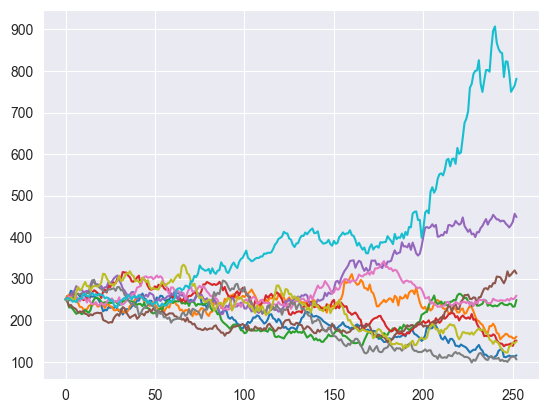

In [5]:
#Demonstration of heston_paths function

S0 = 250

v0 = .35**2

r = .039

t = 1

rho = -.4

kappa = 2

theta = .6**2

xi = .4

mu = .04

n_sims = 10


n_steps = 252


paths = heston_paths(S0, v0, r, t, rho, kappa, theta, xi, mu, n_sims, n_steps)

for path in paths:
    plt.plot(path)
    
plt.show()

In [98]:
#Option data from yfinance


stock_symbol = 'SPY'
ticker = yf.Ticker(stock_symbol)
stock_data = yf.download(stock_symbol, period = '1d', interval = '1m')



expirations = ticker.options


#Create array to store options data
option_data = []

for date in expirations:
    chain = ticker.option_chain(date)

    # Add expiration and label
    calls = chain.calls.copy()
    calls['expiration'] = date
    calls['option_type'] = 'call'

    puts = chain.puts.copy()
    puts['expiration'] = date
    puts['option_type'] = 'put'

    option_data.append(calls)
    option_data.append(puts)

# Combine all into one DataFrame and delete implied volatility column since we'll recalculate.
options_data = pd.concat(option_data, ignore_index=True)
options_data = options_data.drop(columns=['impliedVolatility'])


#Delete any options that were traded in the interval of historical stock values obtained
start_date = stock_data.index[0]
options_data = options_data[options_data['lastTradeDate']>=start_date]


#Insert column of time to expiration in years of the option contract measured from time of last trade
options_data['time_to_expiration'] = options_data.apply(
lambda row: find_tte_yf_options(expiration_date = row['expiration'],
                               last_trade_date = row['lastTradeDate']),
    axis = 1
)


#Add in column of the spot price of stock when the option trade occured.
options_data['spot_price'] = options_data.apply(
    lambda row: yf_find_approx_spot(stock_data['Close'], row['lastTradeDate']),
    axis=1
)
options_data = options_data.dropna()





#Create data frames that keeps relevant information and separate calls from puts.
options_data = options_data[['strike', 'lastPrice', 'lastTradeDate',\
                             'expiration', 'option_type','time_to_expiration', 'spot_price']]
options_data_calls = options_data[(options_data['option_type'] == 'call')].copy()
options_data_puts = options_data[(options_data['option_type'] == 'put')].copy()



#Add implied volatility column in calls data frame 
r = 0.039
options_data_calls['implied_volatility'] = options_data_calls.apply(
    lambda row: implied_volatility_call(
        market_price=row['lastPrice'],
        S0 = row['spot_price'],
        K=row['strike'],
        t=row['time_to_expiration'],
        r=r
    ),
    axis=1
)


#Add implied volatility column in puts data frame 
options_data_puts['implied_volatility'] = options_data_puts.apply(
    lambda row: implied_volatility_put(
        market_price=row['lastPrice'],
        S0 = row['spot_price'],
        K=row['strike'],
        t=row['time_to_expiration'],
        r=r
    ),
    axis=1
)

#Remove rows with undefined values
options_data_calls = options_data_calls.dropna()
options_data_puts = options_data_puts.dropna()

[*********************100%***********************]  1 of 1 completed


In [99]:
options_data_calls

,strike,lastPrice,lastTradeDate,expiration,option_type,time_to_expiration,spot_price,implied_volatility
9,620.0,63.50,2025-10-30 17:14:14+00:00,2025-10-30,call,0.000487,683.369995,1.958931
10,625.0,58.70,2025-10-30 17:17:24+00:00,2025-10-30,call,0.000481,683.599976,1.765374
12,631.0,52.80,2025-10-30 14:56:29+00:00,2025-10-30,call,0.000749,683.760010,1.091807
13,632.0,49.92,2025-10-30 13:37:14+00:00,2025-10-30,call,0.000899,681.690002,1.259409
14,634.0,49.51,2025-10-30 15:40:18+00:00,2025-10-30,call,0.000665,683.400024,1.294299
...,...,...,...,...,...,...,...,...
6905,980.0,4.78,2025-10-30 16:35:17+00:00,2028-01-21,call,2.227958,683.859985,0.125813
6907,990.0,4.26,2025-10-30 16:09:47+00:00,2028-01-21,call,2.228007,684.770020,0.125396
6908,995.0,4.05,2025-10-30 15:00:58+00:00,2028-01-21,call,2.228137,684.609985,0.125715
6909,1000.0,3.83,2025-10-30 16:49:34+00:00,2028-01-21,call,2.227931,684.340027,0.125956


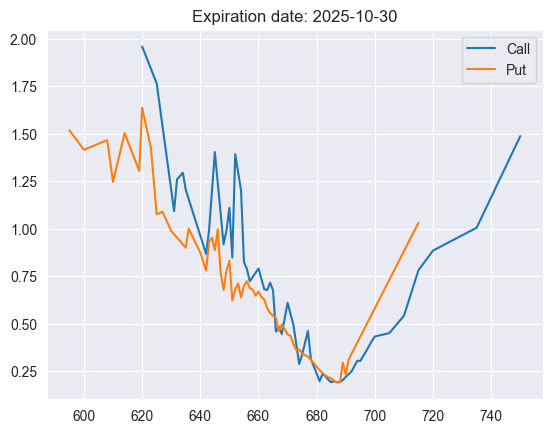

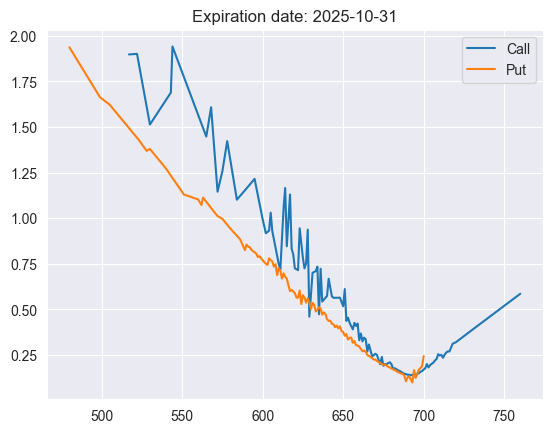

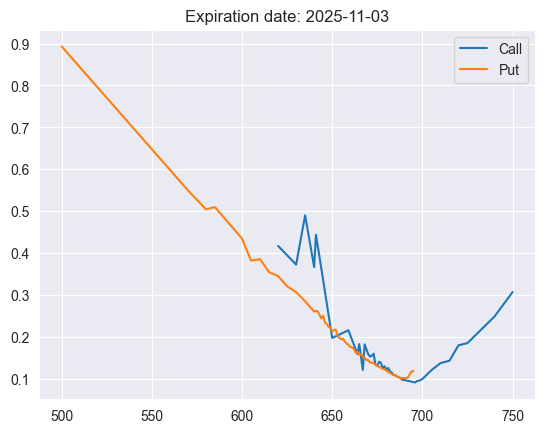

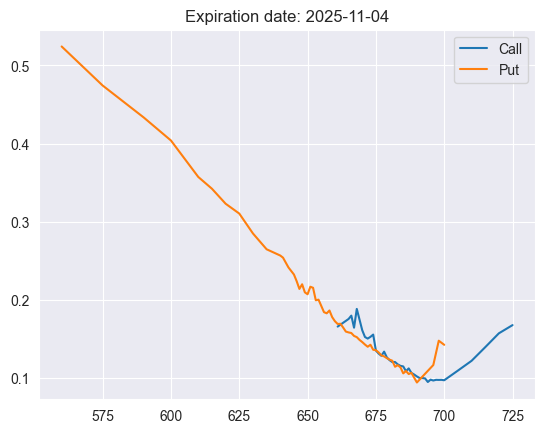

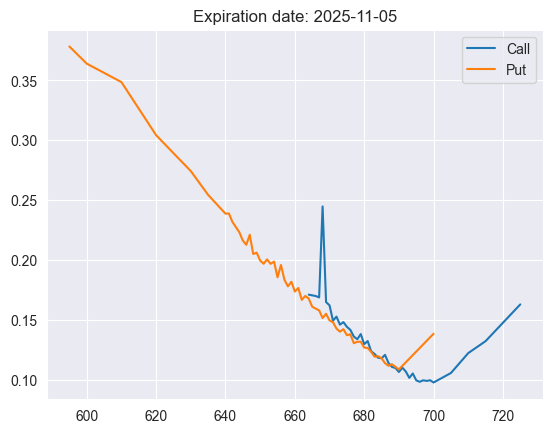

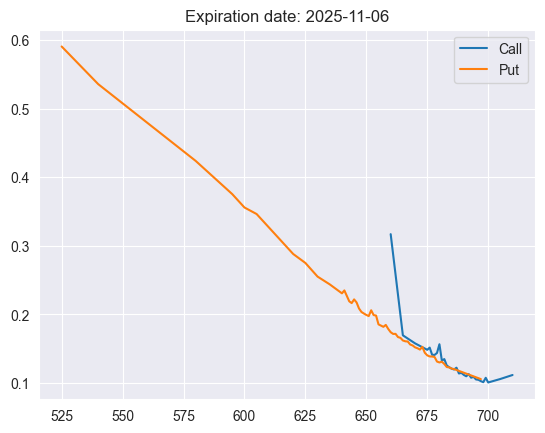

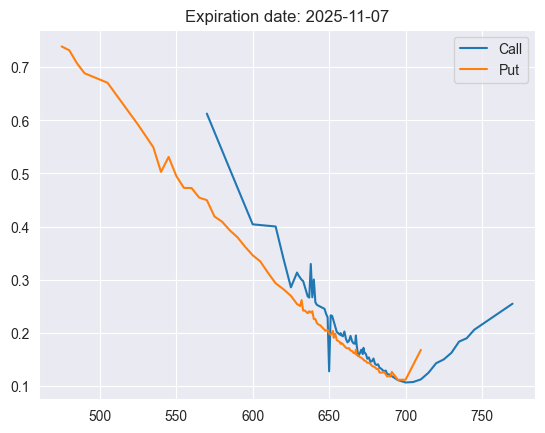

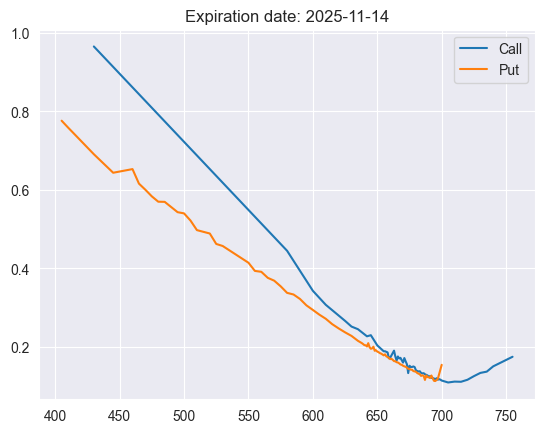

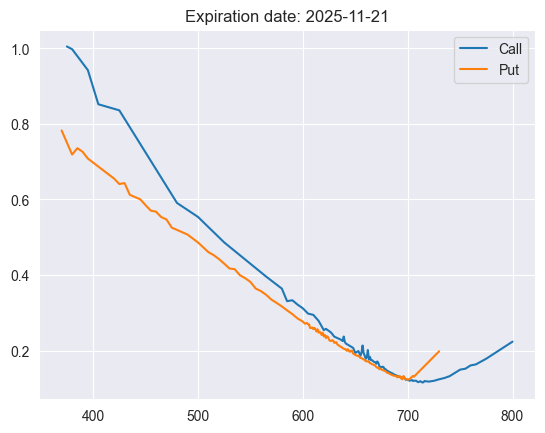

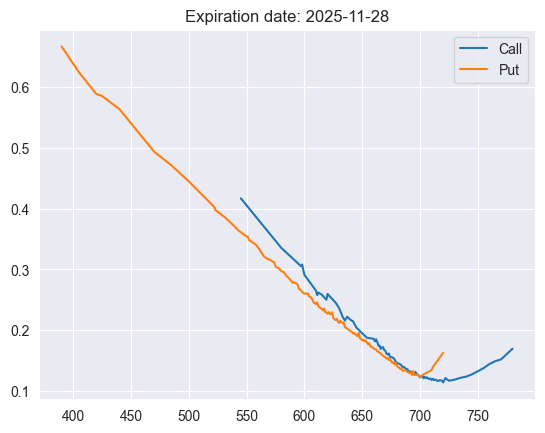

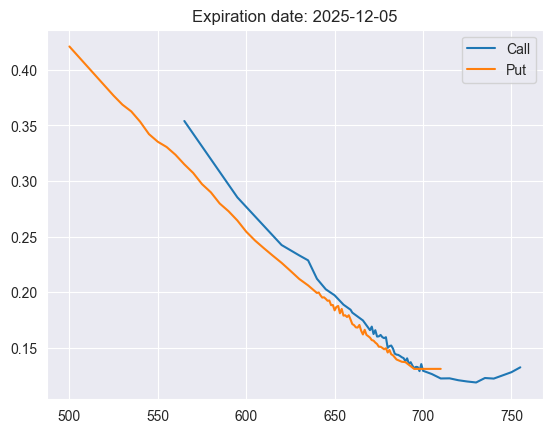

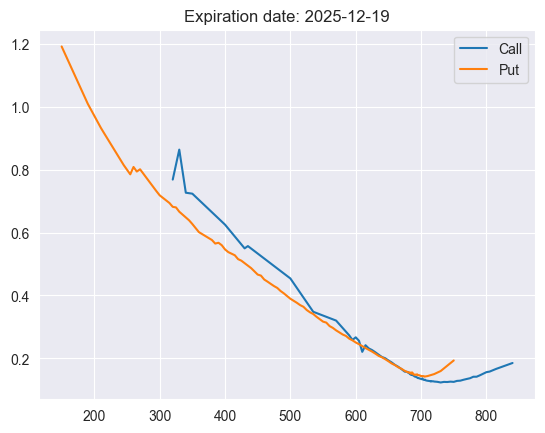

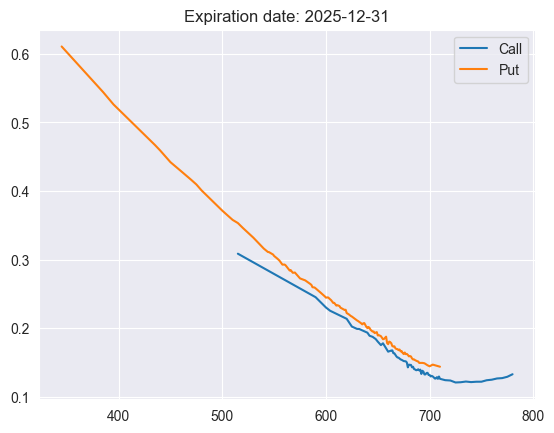

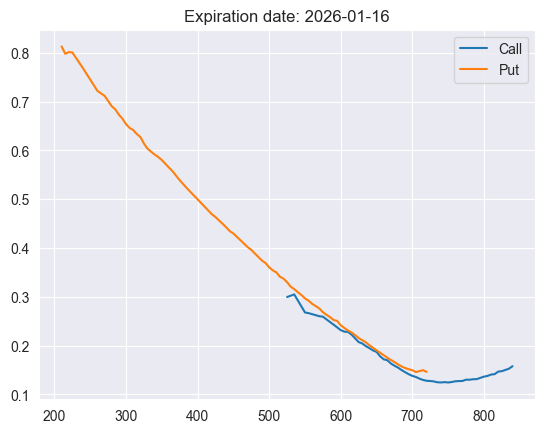

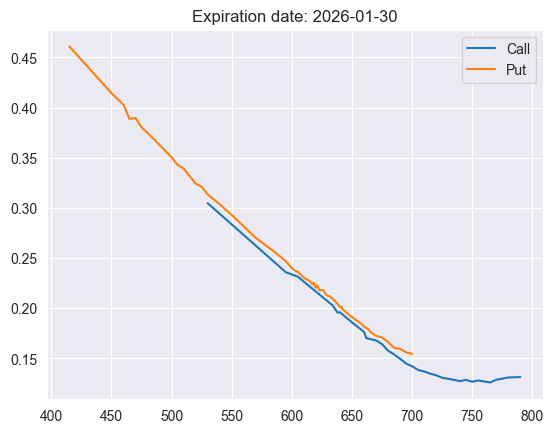

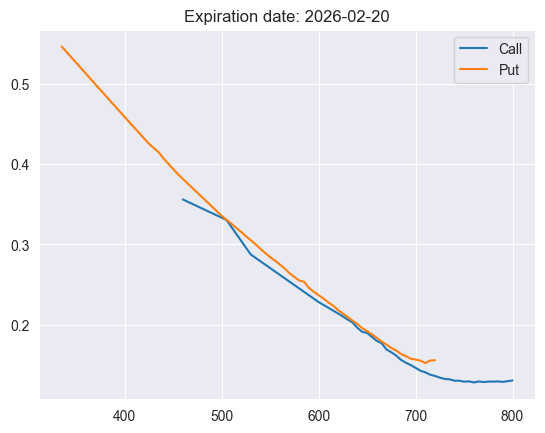

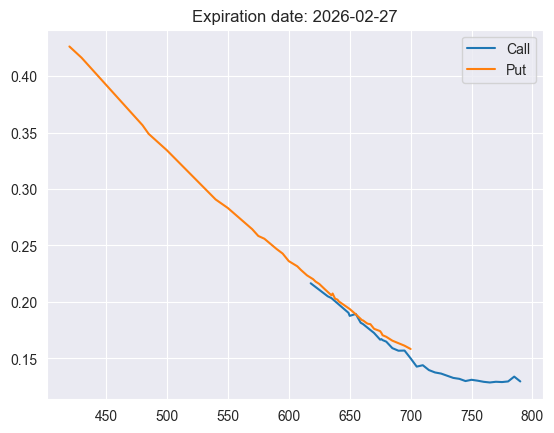

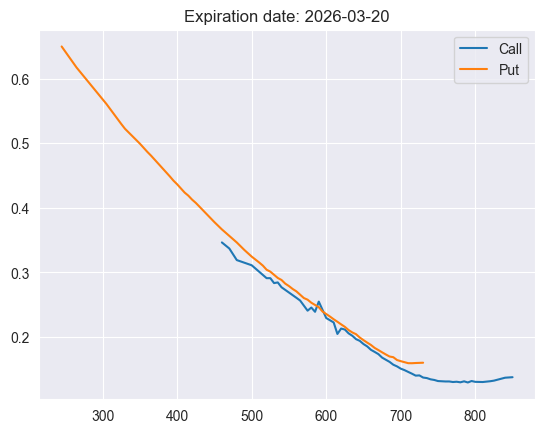

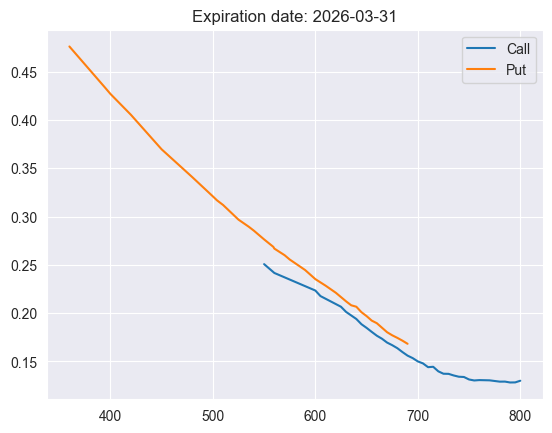

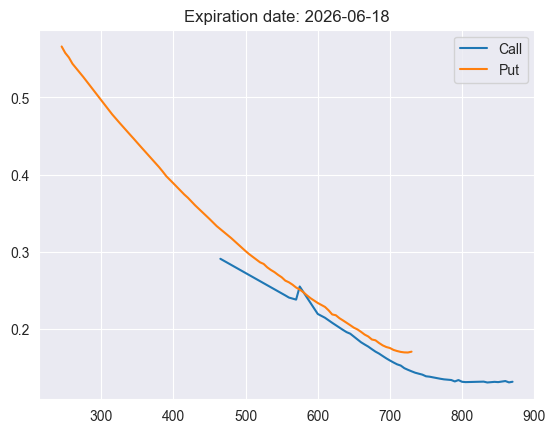

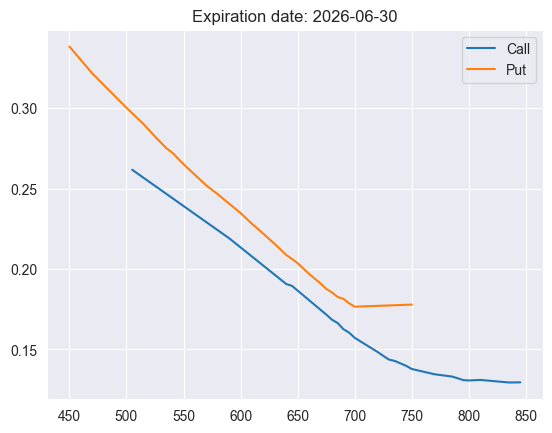

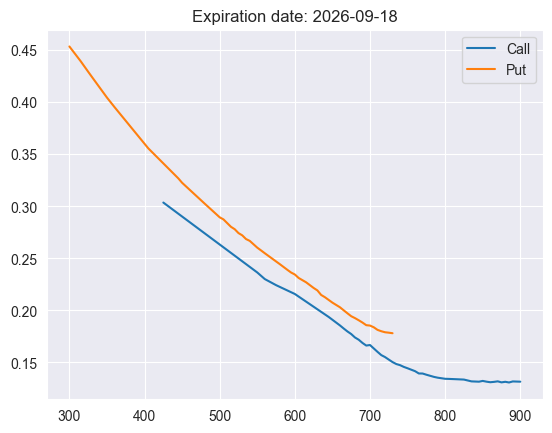

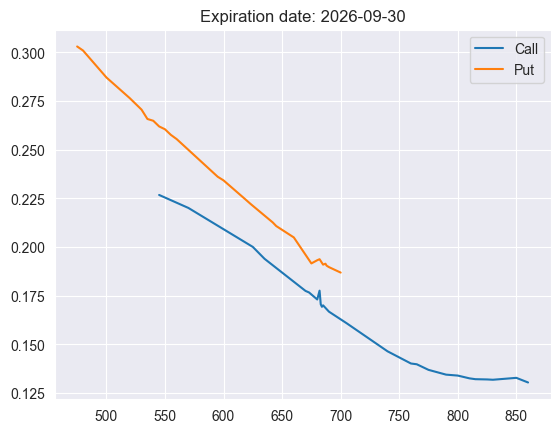

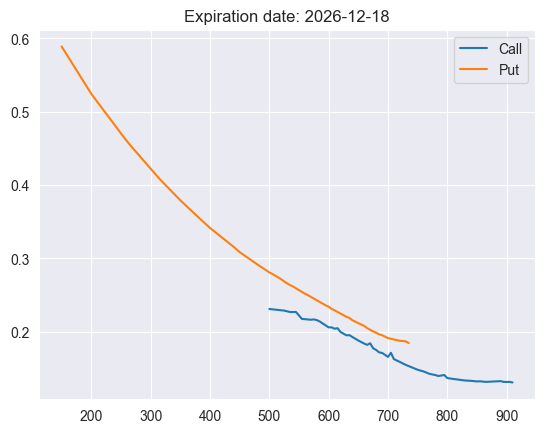

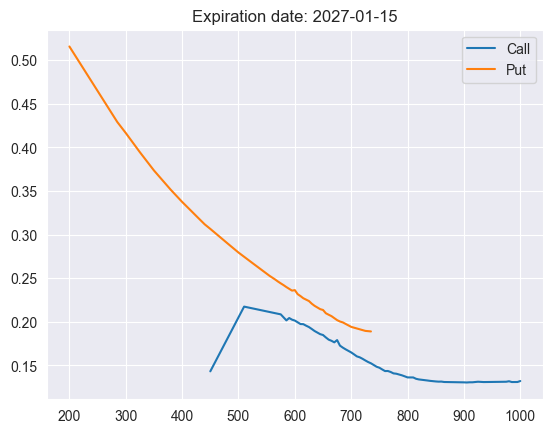

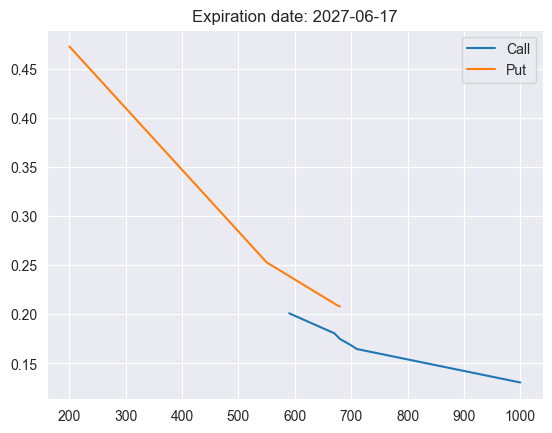

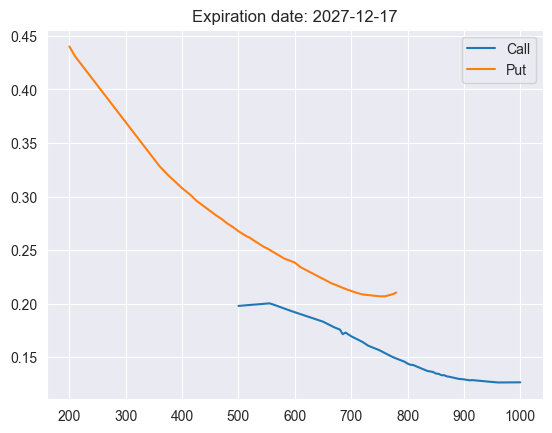

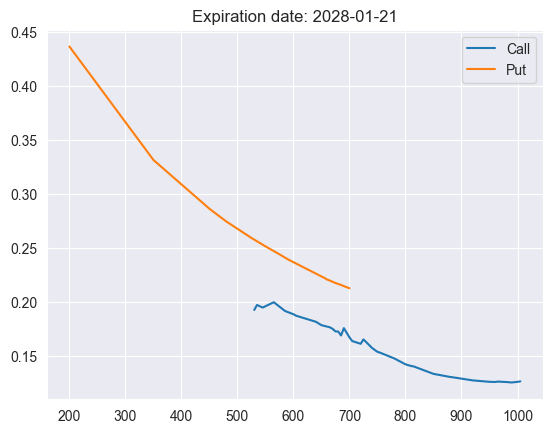

In [100]:
### Data visualization of option volatility smiles


for date in expirations:
    
    call_data = options_data_calls[options_data_calls['expiration'] == date]
    call_strikes = call_data['strike']
    call_imp_vol = call_data['implied_volatility']
    
    put_data = options_data_puts[options_data_puts['expiration'] == date]
    put_strikes = put_data['strike']
    put_imp_vol = put_data['implied_volatility']
    
    plt.plot(call_strikes.values, call_imp_vol.values, label = 'Call')
    plt.plot(put_strikes.values, put_imp_vol.values, label = 'Put')
    
    plt.title(f'Expiration date: {date}')
    plt.legend()
    plt.show()

In [ ]:
#For our Heston calibration, we can specify our choice of parameters




In [106]:
dates = ['2026-03-20']#Insert dates that have reasonable volatility smiles

options_data_calls_cleaned = options_data_calls[options_data_calls['expiration'].isin(dates)]
options_data_puts_cleaned = options_data_puts[options_data_puts['expiration'].isin(dates)]


options_data_cleaned = pd.concat(
    [options_data_calls_cleaned, options_data_puts_cleaned],
    ignore_index=True)

In [107]:
options_data_cleaned

,strike,lastPrice,lastTradeDate,expiration,option_type,time_to_expiration,spot_price,implied_volatility
0,460.0,231.54,2025-10-30 13:30:13+00:00,2026-03-20,call,0.387214,683.349976,0.346252
1,470.0,222.18,2025-10-30 14:27:18+00:00,2026-03-20,call,0.387106,683.700012,0.336835
2,480.0,211.00,2025-10-30 13:43:27+00:00,2026-03-20,call,0.387189,682.390015,0.318934
3,500.0,192.00,2025-10-30 13:43:34+00:00,2026-03-20,call,0.387189,682.390015,0.310900
4,520.0,174.00,2025-10-30 14:27:55+00:00,2026-03-20,call,0.387104,683.700012,0.290917
...,...,...,...,...,...,...,...,...
116,700.0,30.22,2025-10-30 17:28:09+00:00,2026-03-20,put,0.386762,684.559998,0.162392
117,710.0,35.56,2025-10-30 14:21:30+00:00,2026-03-20,put,0.387117,684.239990,0.159267
118,715.0,40.20,2025-10-30 13:41:48+00:00,2026-03-20,put,0.387192,681.594971,0.159205
119,720.0,41.75,2025-10-30 15:34:50+00:00,2026-03-20,put,0.386977,684.385010,0.159540


In [11]:
###Calibrate Heston model to option data using gradient descent

### We will calibrate all 5 parameters

### Goal will be to find values of the 5 parameters minimizing the following function

def objective(params, data, r):
    kappa, v0, xi, rho, theta = params
    
    error = 0
    for _, row in data.iterrows():
        model_price = heston_option(
            S0=row['spot_price'],
            K=row['strike'],
            v0=v0,
            r=r,
            t=row['time_to_expiration'],
            kappa=kappa,
            theta=theta,
            xi=xi,
            rho=rho,
            option_type = row['option_type']
        )
        market_price = row['lastPrice']
        error += (model_price - market_price) ** 2
        
    return error / len(data)




In [12]:
help(heston_option)

Help on function heston_option in module __main__:

heston_option(S0, K, v0, r, t, kappa, theta, xi, rho, option_type)
    Price of a call option under Heston model
    
    Parameters:
    - S0 (float): Initial stock price
    - K (float): Strike Price
    - v0 (float): Initial variance
    - r (float): Risk-free interest rate
    - t (float): Time-to-expiration (in years)
    - kappa (float): Rate of mean reversion of variance (1 to 5)
    - theta (float): Long-run variance
    - xi (float): Volatility of volatility (.2 to 1)
    - rho (float): Correlation between Brownian motions (-.9 to -.2)
    - option_type (string): 'call' for call and 'put' for put
    
    Returns:
    - price (float): Option price



In [20]:
options_data_calls_cleaned

,strike,lastPrice,lastTradeDate,expiration,option_type,time_to_expiration,spot_price,implied_volatility
226,230.0,41.19,2025-10-30 15:32:31+00:00,2025-11-14,call,0.041776,270.489990,0.445707
227,235.0,37.00,2025-10-30 16:00:25+00:00,2025-11-14,call,0.041723,271.339508,0.392410
229,245.0,27.50,2025-10-30 15:56:25+00:00,2025-11-14,call,0.041731,271.640015,0.332116
230,250.0,22.87,2025-10-30 16:32:55+00:00,2025-11-14,call,0.041661,271.845001,0.303390
231,255.0,18.41,2025-10-30 16:32:40+00:00,2025-11-14,call,0.041662,271.845001,0.298467
...,...,...,...,...,...,...,...,...
1085,360.0,2.31,2025-10-30 16:30:07+00:00,2026-05-15,call,0.540297,271.859985,0.258470
1086,370.0,1.51,2025-10-30 14:13:36+00:00,2026-05-15,call,0.540556,270.320007,0.255870
1087,380.0,1.30,2025-10-30 16:12:25+00:00,2026-05-15,call,0.540330,271.588013,0.261745
1088,390.0,0.94,2025-10-30 15:22:52+00:00,2026-05-15,call,0.540425,270.975006,0.262816


In [108]:
#need to create a reasonable first guess and set bounds for our model calibration

initial_guess = [3, .4**2, .6, -.6,.4**2]  #kappa, v0, xi, rho, theta
bounds = [(.01, 8), (.1**2, .9**2), (.01, 2), (-1,-0.01), (.1**2, .9**2)] 

r = .039



data_sample = options_data_calls_cleaned.sample(30)




result = minimize(
    objective,
    initial_guess,
    args=(data_sample, r),
    bounds=bounds,
    method='L-BFGS-B',
    options={
        'disp': True,
        'maxiter': 20,       
        'ftol': 1e-4,         
        'gtol': 1e-4          
    }
)


calibrated_params = result.x

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.93928D+02    |proj g|=  2.99000D+00

At iterate    1    f=  1.21072D+02    |proj g|=  1.99000D+00

At iterate    2    f=  1.89239D+01    |proj g|=  1.68845D+00

At iterate    3    f=  1.60381D+01    |proj g|=  4.46213D+00

At iterate    4    f=  1.16974D+01    |proj g|=  3.06376D+00

At iterate    5    f=  7.48131D+00    |proj g|=  2.37362D+00

At iterate    6    f=  1.92125D+00    |proj g|=  1.93302D+00

At iterate    7    f=  6.30061D-01    |proj g|=  1.09288D+00

At iterate    8    f=  1.67398D-01    |proj g|=  6.73202D-01

At iterate    9    f=  1.25430D-01    |proj g|=  6.61188D-01

At iterate   10    f=  1.22822D-01    |proj g|=  7.97221D-01

At iterate   11    f=  1.21613D-01    |proj g|=  7.97044D-01

At iterate   12    f=  1.17660D-01    |proj g|=  7.95863D-01

At iterate   13    f=  1.1

In [109]:
kappa, v0, xi, rho, theta = calibrated_params

In [110]:
kappa, np.sqrt(v0), xi, rho, np.sqrt(theta)

(2.2109562358486876,
 0.1483184800194616,
 0.9740279807084669,
 -0.6293959513888353,
 0.24899029837800643)

In [74]:
kappa, v0, xi, rho, theta = calibrated_params

In [75]:
kappa, np.sqrt(v0), xi, rho, np.sqrt(theta)

(2.936305920391206,
 0.6056964313796135,
 1.5306134894259114,
 -0.01006536070713752,
 0.1)

In [22]:
kappa, v0, xi, rho, theta = calibrated_params

In [23]:
kappa, np.sqrt(v0), xi, rho, np.sqrt(theta)

(3.095738778197317,
 0.2612643990088815,
 0.5684827707945018,
 -0.4055902097097646,
 0.2949036280978698)

In [111]:
#Backtest a hedging strategy using Heston delta hedging with fitted parameters

stock_data =yf.download(stock_symbol, period = '2y', interval = '1d')

[*********************100%***********************]  1 of 1 completed


In [46]:
stock_path

array([232.31877136, 232.58752441, 229.03407288, 224.86347961,
       221.87738037, 220.98155212, 222.41485596, 221.68826294,
       226.42619324, 226.15716553, 223.43681335, 223.43681335,
       224.32365417, 227.41270447, 224.20410156, 227.21342468,
       227.4724884 , 228.18994141, 227.71165466, 229.05686951,
       232.04624939, 234.22850037, 234.09895325, 236.49047852,
       238.74247742, 241.79165649, 242.15037537, 242.18028259,
       241.98098755, 245.87715149, 246.89355469, 245.61808777,
       247.08288574, 247.25228882, 250.15196228, 252.58334351,
       247.17256165, 248.90638733, 253.58976746, 254.36701965,
       257.28665161, 258.10372925, 254.68586731, 251.30786133,
       249.53417969, 242.9874115 , 242.49914551, 244.13334656,
       241.35321045, 241.84147644, 236.01219177, 233.57084656,
       232.45480347, 237.02856445, 227.45256042, 229.16647339,
       221.85243225, 223.03823853, 222.86885071, 221.99194336,
       229.04690552, 237.41717529, 238.51329041, 236.74

In [113]:
rol_sigmas = (np.log((stock_data['Close'][stock_symbol].pct_change()+1)).std()*np.sqrt(252))


In [114]:
rol_sigmas

0.16203844034566883

In [116]:
t = 1

n_steps = 252

dt = t/n_steps



stock_path = np.array(stock_data['Close'][stock_symbol].values[-n_steps-1:])

rol_sigmas = (np.log((stock_data['Close'][stock_symbol].pct_change()+1)).rolling(window = 21).std()*np.sqrt(252))[-n_steps-1:]

rol_vols = rol_sigmas**2

K = stock_path[0]

deltas = np.zeros(n_steps)

times = np.linspace(0,t, n_steps + 1)

for i in range(n_steps):
    deltas[i] = heston_call_delta(stock_path[i], K, rol_vols.iloc[i], r, (t-times)[i], kappa, theta, xi, rho)

stock_profits = (stock_path[1:n_steps+1] - stock_path[0:n_steps]*np.exp(r*dt))*np.exp(-r*times[1:n_steps+1])*deltas

total_stock_profit = np.sum(stock_profits)

call_payout = np.maximum(stock_path[-1] - K, 0)*np.exp(-r*t)


call_profit_hedged = -call_payout + total_stock_profit

heston_call_price = heston_call(stock_path[0], K, rol_vols.iloc[0], r, t, kappa, theta, xi, rho)

In [117]:
call_profit_hedged, heston_call_price

(-52.01036728607312, 51.650022798051)

In [94]:
rho

-0.01006536070713752